# Reward building

# Overview of ideas:

Utility / potential-based / reward shaping function combination:
- Distance weighted align ball to goal:
	- Expected values of align ball to goal are higher near the player team goal. This is not very good, we need to make sure weight is not that high.
	- Solution: use an alignment score that gets higher as the player approaches the ball
- Ball to goal wall distance / y coord:
	- The higher the y axis value the more the team pushes the opponent team to defend
- Distance ball to goal: 
	- One of the two best possible rewards
- Distance player to ball:
	- Increases control strength
- Velocity ball to goal: 
	- One of the two best possible rewards
	- Increases probability of scoring
- Velocity player to ball:
	- Players should chase after the ball
- Offensive potential:
	- Velocity player to ball is mediocre as a reward, but very powerful under certain circumstances, e.g. when the player to ball and ball to goal position vectors align and the player is near the ball as well.
	- Proposal 1: enhance the reward by player to ball and ball to goal offensive vector alignment
    - Proposal 2: enhance the reward by player to ball distance, since players that are far away have a lower chance of scoring.

Reward:
- Touch ball with acceleration (difference between current and previous ball linear velocity) toward goal (current ball linear velocity vector and ball to goal position vector alignment)
- Potential-based save boost reward:
    - Maintain a previous boost value and compute the difference between the current and the previous value, inversely weighted by the absolute value of the utility score. This means that the larger or smaller the utility, the more in demand would be to use boost, and thus the smaller the cost of using it.
- Event rewards:
	- Demolish and demolished
	- Goal / team goal and concede
	- Shot (as detected by the game)
	- Save (as detected by the game)

------

- But what kind of weights?
- How to distribute reward between multiple agents of different purposes?


Import needed libraries

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.analysis import plotting, generate
from utils.analysis.reward_functions import common, custom
from rlgym.utils import common_values
import pandas as pd
import seaborn as sns

Retrieve arena positions

In [3]:
arena_positions = plotting.arena_positions

Generate uniformly distributed dummy data

In [4]:
grid_positions = generate.grid_positions()
player_velocities = np.linspace((1327.9,) * 3, (0,) * 3, 8)
ball_velocities = np.linspace((3464.1,) * 3, (0,) * 3, 8)
forward_vectors = generate.sphere_points()

Training measurements

In [5]:
# maximum episode length in seconds
max_episode_len = 300
# default frame skip
frame_skip = 8
# the number of seconds it takes the gamma exponential to reach 0.5
half_life_seconds = 10
# game physics engine runs at 120 Hz\fps
fps = 120 // frame_skip
# inverse function gamma computation
gamma = np.exp(np.log(0.5) / (fps * half_life_seconds))

In [6]:
gamma

0.9953896791032291

Average values for a standard game, based on ballchasing data

In [7]:
average_ball_vel = common_values.BALL_MAX_SPEED * 0.6 // fps
average_car_vel = common_values.CAR_MAX_SPEED * 0.65 // fps

average_ball_height = 900
average_car_height = 300
# We assume a case for which the blue team is winning in offense / scoring a goal
average_ball2goal_vel = 2000 // fps
average_car2ball_vel = 850 // fps

We set up a 2v2 scenario for blue offense

In [8]:
ball_position = np.array([-1800, 1800, 400])
ball_lin_velocity = np.array([1000, 3500, -40], dtype=float)

blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)
team_idx = [0, 0, 1, 1]

blue_lin_vels = np.array([[-1200, 600, 0], [-1200, 900, 0]])
orange_lin_vels = np.array([[200, -700, 150], [-1000, -1100, 400]])
player_lin_vels = (blue_lin_vels, orange_lin_vels)

## Utility function reward visualization

We would like to first visualize necessary reward function values.

`val`s are single value rewards computed for objects other than the player, while `zs`s are 2d numpy arrays that correspond to reward values for each position in the arena plot.

All rewards are computed for blue player with index 0.

### Distance weighted align ball to goal

We use defense and offense weights of 0.5 to produce values between -1 and 1.

In [9]:
dist_weight_align_ball_zs = custom.dist_weighted_align_ball(arena_positions, 
                                                            ball_position, 
                                                            defense=0.5, 
                                                            offense=0.5,
                                                            dispersion=1,
                                                            density=1
                                                           )

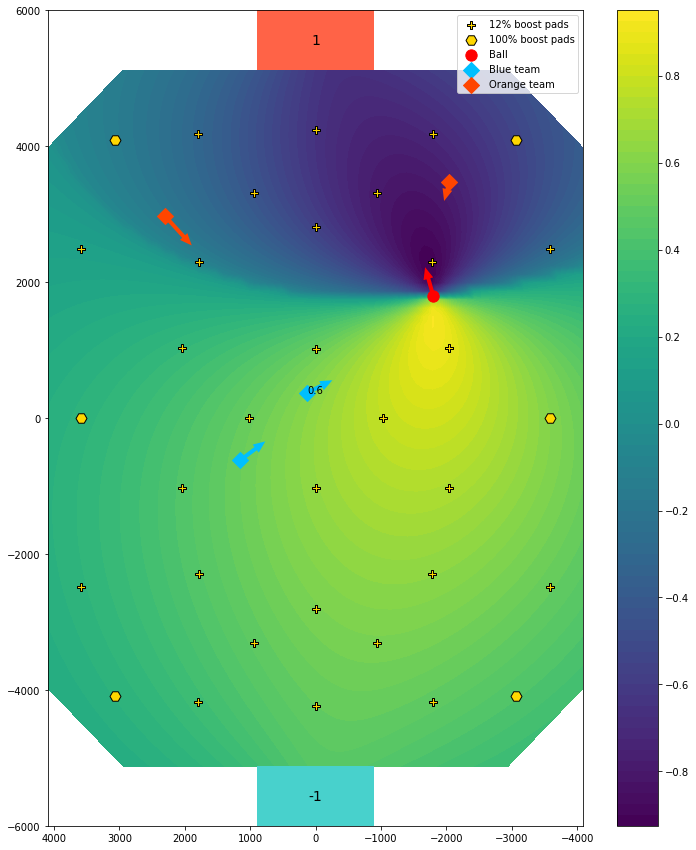

In [10]:
plotting.arena_contour(dist_weight_align_ball_zs,
                      ball_position=ball_position,
                      ball_lin_vel=ball_lin_velocity,
                      player_positions=player_positions,
                      player_lin_vels=player_lin_vels)

### Ball y coord

In [11]:
ball_y_coord_val = common.ball_y_coord(ball_position[None])

In [12]:
ball_y_coord_val

array([0.34530718])

### Distance ball to goal

We use a dispersion factor of 1.1

In [13]:
signed_liu_dist_ball2goal_val = custom.signed_liu_dist_ball2goal(ball_position, dispersion=1.1)

In [14]:
signed_liu_dist_ball2goal_val

0.39841623309655283

### Distance player to ball

In [15]:
liu_dist_player2ball_zs = custom.liu_dist_player2ball(arena_positions, ball_position)

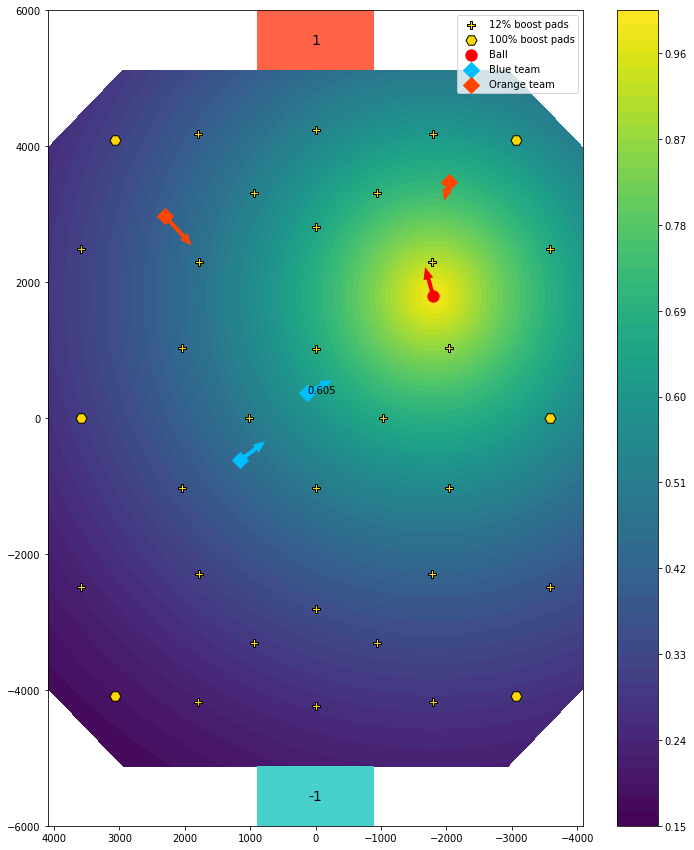

In [16]:
plotting.arena_contour(liu_dist_player2ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels
                      )

### Velocity ball to goal

In [17]:
velocity_ball2goal_val = common.velocity_ball2goal(ball_position[None], ball_lin_velocity)

In [18]:
velocity_ball2goal_val

array([0.60184678])

### Velocity player to ball

In [19]:
velocity_player2ball_zs = common.velocity_player2ball(arena_positions, 
                                                       blue_lin_vels[0],
                                                       ball_position)

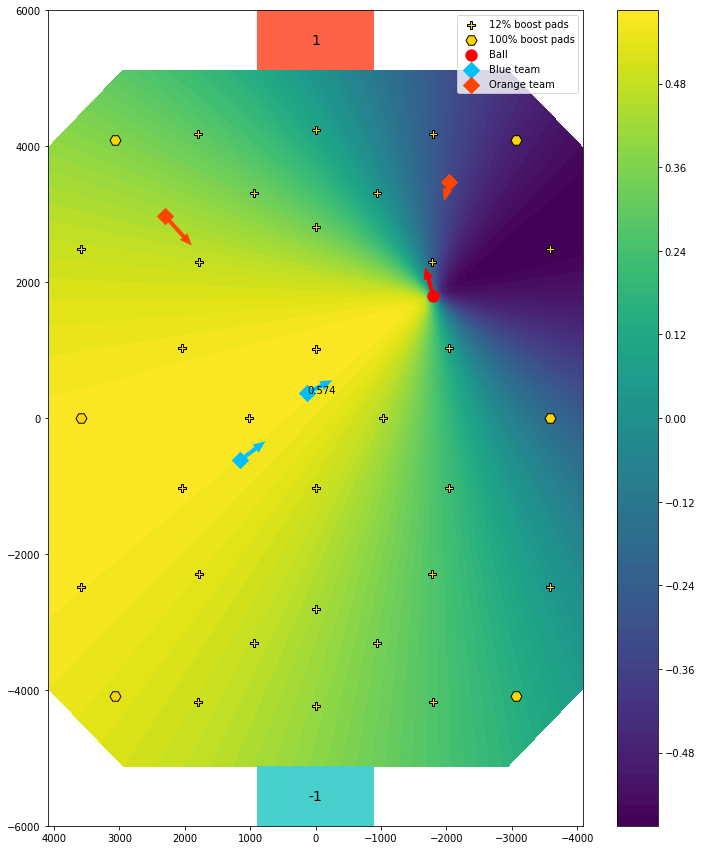

In [20]:
plotting.arena_contour(velocity_player2ball_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                      )

### Offensive potential

In [21]:
offensive_potential_zs = custom.offensive_potential(arena_positions,
                                             ball_position, 
                                             blue_lin_vels[0],
                                             0.5, 0.5
                                            )

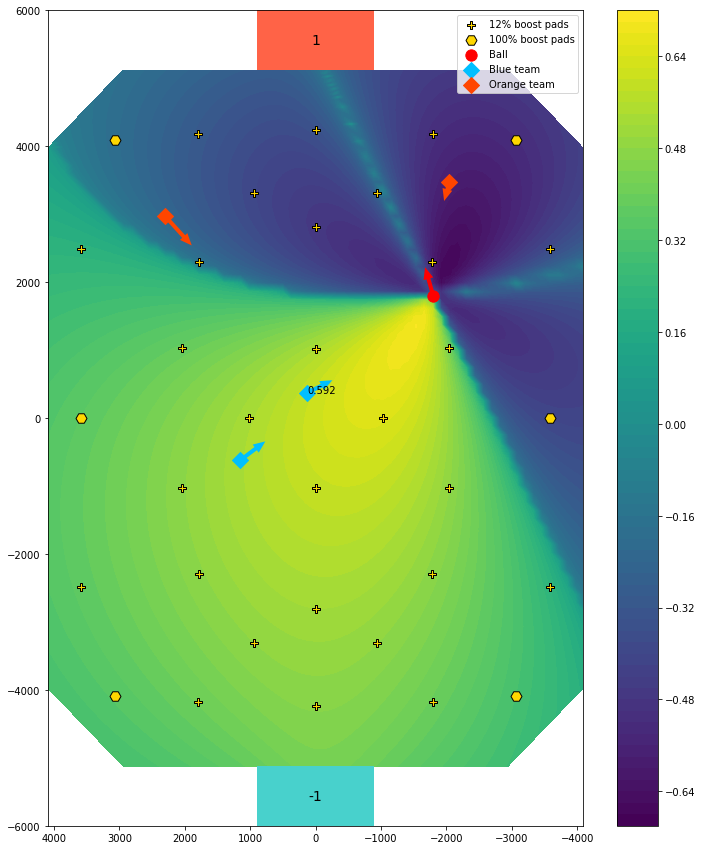

In [22]:
plotting.arena_contour(offensive_potential_zs,
                       ball_position, 
                       ball_lin_velocity, 
                       player_positions,
                       player_lin_vels)

## Utility reward building

We need to make sure that the reward shaping potential value difference between time frames is not large enough to affect the ultimate goal, which is to score.

Reward values are largely inspired by the Necto reward.

In [23]:
def make_utility(player_position,
                 player_lin_velocity,
                 ball_position,
                 ball_lin_velocity,
                 orange=False):
    rew = (custom.dist_weighted_align_ball(player_position, ball_position, orange=orange) * 0.75 +
           common.ball_y_coord(ball_position[None]) * 1 * -(orange - 0.5) * 2 + 
           custom.signed_liu_dist_ball2goal(ball_position, dispersion=1.1, own_goal=orange) * 5 +
           custom.liu_dist_player2ball(player_position, ball_position) * 0.5 +
           common.velocity_ball2goal(ball_position[None], ball_lin_velocity) * 2 +
           common.velocity_player2ball(player_position, player_lin_velocity, ball_position) * 0.25 +
           custom.offensive_potential(player_position, ball_position, 
                                      player_lin_velocity, orange=orange) * 5
          )
    return rew

In [24]:
utility_zs = make_utility(arena_positions,
                          blue_lin_vels[1],
                          ball_position,
                          ball_lin_velocity,
                          False
                         )

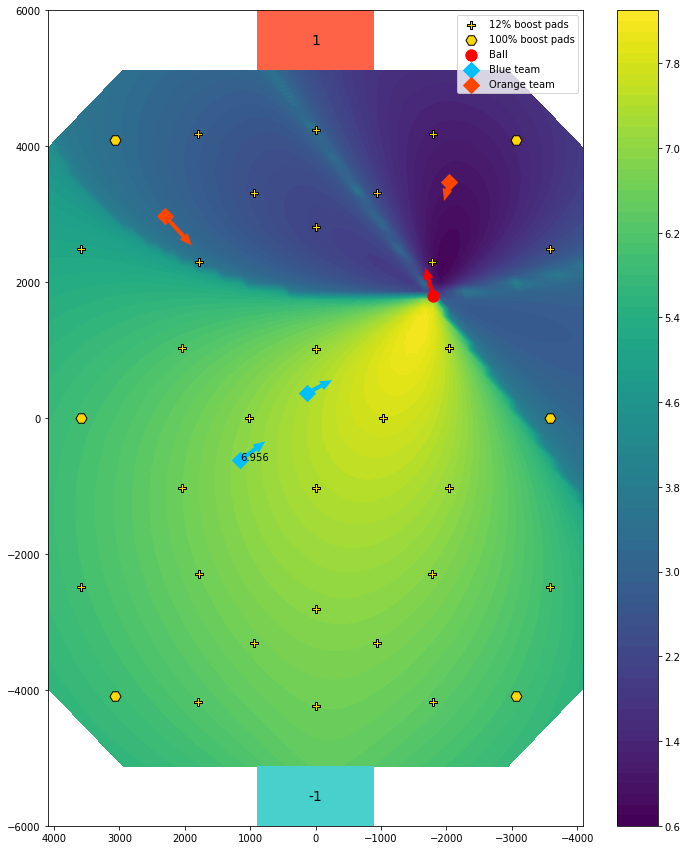

In [25]:
plotting.arena_contour(utility_zs,
                       ball_position, 
                       ball_lin_velocity, 
                       player_positions,
                       player_lin_vels,
                       player_idx=1)

Offensive potential tests

In [26]:
some_vel = np.array([400, 1500, 80])
some_vel = np.array([-800, 1000, 80])
# some_vel = np.array([1800, 0, 0])
# some_vel = np.array([0, -1800, 50])

In [27]:
some_pos = np.array([-1300, 3000, 150])
# some_pos = np.array([-2400, 0, 150])
# some_pos = np.array([-2400, -2000, 150])
some_pos = np.array([0, -2400, 150])

In [28]:
some_ball_pos = np.array([0, 0, 93])

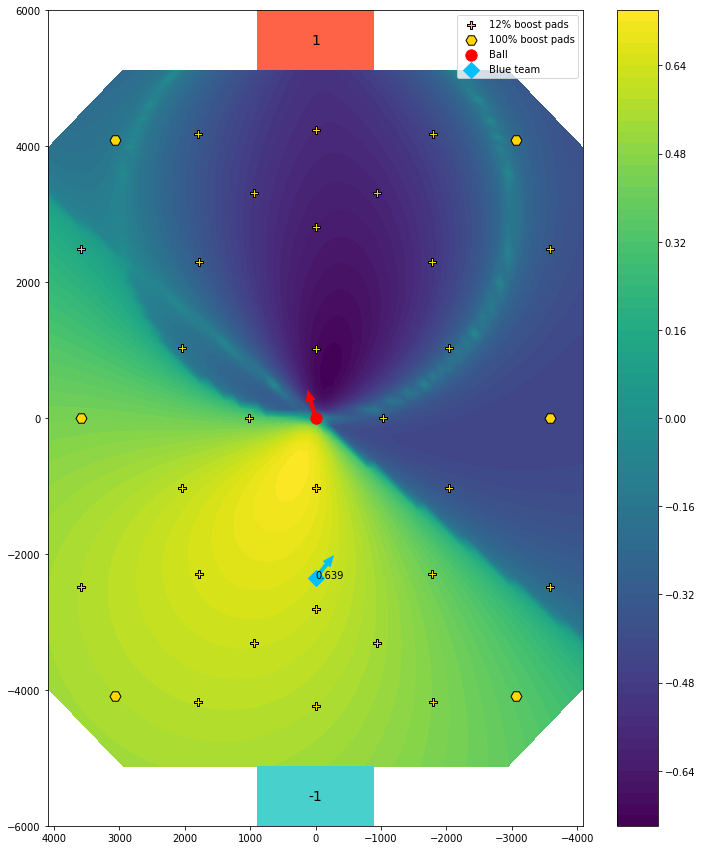

In [29]:
plotting.arena_contour(custom.offensive_potential(arena_positions, some_ball_pos, some_vel, 0, 1),
                       some_ball_pos, 
                       ball_lin_velocity, 
                       some_pos[None],
                       some_vel[None])